<a href="https://colab.research.google.com/github/SaraElwatany/Lung-TumorDetection-Segmentation/blob/main/inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Imports**

In [21]:
import os
import cv2
import torch
import numpy as np
import torch.nn as nn
from PIL import Image
from google.colab import drive
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, random_split

In [13]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## **Helper Functions**

In [78]:
def segment_tumor(image_path, model, detection=False, mask_path=None):

  """
  Perform tumor segmentation on an input image using a trained model.

  This function supports two modes:
  - Detection mode: expects a small cropped RGB tumor image and resizes it to 64x64.
  - Full image segmentation mode: expects a grayscale image and resizes it to 256x256.

  Args:
      image_path (str): Path to the input image file.
      model (torch.nn.Module): Trained PyTorch model for tumor segmentation.
      detection (bool, optional): If True, perform inference on a cropped tumor patch.
                                  If False, perform segmentation on the full grayscale image. Default is False.

  Returns:
      None: Displays the input image and predicted mask using matplotlib.
  """


  # Perform inference on the cropped tumor
  if detection:

      # Load and convert image
      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image_pil = Image.fromarray(image)

      # Resize to (64, 64)
      image_pil = image_pil.resize((64, 64))

      # Normalize and convert to tensor
      image = np.array(image_pil).astype(np.float32) / 255.0
      image = np.transpose(image, (2, 0, 1))  # HWC to CHW
      input_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).to(device)

      mask_img = None  #



  # Perform inference on the whole input image
  else:

    # Load image
    image = Image.open(image_path).convert("L")              # Convert to grayscale

    if mask_path:
      mask_img = Image.open(mask_path).convert("L")   # Convert to grayscale
    else:
      mask_img = None


    # Define transform (same as training)
    transform = T.Compose([
                            T.Resize((256, 256)),  # adjust to match training input size
                            T.ToTensor()
                         ])


    # Transform and add batch dimension
    input_tensor = transform(image).unsqueeze(0).to(device)         # Shape: [1, 1, H, W]



  # Forward pass
  with torch.no_grad():
      output = model(input_tensor)
      output = torch.sigmoid(output)      # Convert logits to probabilities
      pred_mask = (output > 0.1).float()  # Threshold for binary mask


  # Visualize
  if detection:
      plt.subplot(1, 3, 1)
      plt.title("Input Image")
      image_display = np.transpose(image, (1, 2, 0))  # CHW to HWC
      plt.imshow(image_display)
  else:
      plt.subplot(1, 3, 1)
      plt.title("Input Image")
      plt.imshow(image, cmap='gray')


  if mask_img is not None:
      plt.subplot(1, 3, 3)
      plt.title("True Mask")
      plt.imshow(mask_img, cmap='gray')

  plt.subplot(1, 3, 2)
  plt.title("Predicted Mask")
  plt.imshow(pred_mask.squeeze().cpu(), cmap='gray')

  plt.show()

## **Tumor Segmentation on Whole Image**

In [55]:
def double_convolution(in_channels, out_channels):
    """
    In the original paper implementation, the convolution operations were
    not padded but we are padding them here. This is because, we need the
    output result size to be same as input size.
    """
    conv_op = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                            nn.ReLU(inplace=True),

                            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                            nn.ReLU(inplace=True)
                           )
    return conv_op

In [56]:
class UNet(nn.Module):


    def __init__(self, num_classes):

        super(UNet, self).__init__()

        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)

        # Contracting path.

        # Each convolution is applied twice.
        self.down_convolution_1 = double_convolution(1, 64)
        self.down_convolution_2 = double_convolution(64, 128)
        self.down_convolution_3 = double_convolution(128, 256)
        self.down_convolution_4 = double_convolution(256, 512)
        self.down_convolution_5 = double_convolution(512, 1024)


        # Expanding path.
        self.up_transpose_1 = nn.ConvTranspose2d(
                                                in_channels=1024, out_channels=512,
                                                kernel_size=2,
                                                stride=2)

        # Below, `in_channels` again becomes 1024 as we are concatinating.
        self.up_convolution_1 = double_convolution(1024, 512)

        self.up_transpose_2 = nn.ConvTranspose2d(
                                                  in_channels=512, out_channels=256,
                                                  kernel_size=2,
                                                  stride=2)

        self.up_convolution_2 = double_convolution(512, 256)

        self.up_transpose_3 = nn.ConvTranspose2d(
                                                  in_channels=256, out_channels=128,
                                                  kernel_size=2,
                                                  stride=2)

        self.up_convolution_3 = double_convolution(256, 128)

        self.up_transpose_4 = nn.ConvTranspose2d(
                                                  in_channels=128, out_channels=64,
                                                  kernel_size=2,
                                                  stride=2)

        self.up_convolution_4 = double_convolution(128, 64)

        # output => `out_channels` as per the number of classes.
        self.out = nn.Conv2d(
                              in_channels=64, out_channels=num_classes,
                              kernel_size=1
                            )



    def forward(self, x):

        down_1 = self.down_convolution_1(x)
        down_2 = self.max_pool2d(down_1)
        down_3 = self.down_convolution_2(down_2)
        down_4 = self.max_pool2d(down_3)
        down_5 = self.down_convolution_3(down_4)
        down_6 = self.max_pool2d(down_5)
        down_7 = self.down_convolution_4(down_6)
        down_8 = self.max_pool2d(down_7)
        down_9 = self.down_convolution_5(down_8)

        # *** DO NOT APPLY MAX POOL TO down_9 ***

        up_1 = self.up_transpose_1(down_9)
        x = self.up_convolution_1(torch.cat([down_7, up_1], 1))

        up_2 = self.up_transpose_2(x)
        x = self.up_convolution_2(torch.cat([down_5, up_2], 1))

        up_3 = self.up_transpose_3(x)
        x = self.up_convolution_3(torch.cat([down_3, up_3], 1))

        up_4 = self.up_transpose_4(x)
        x = self.up_convolution_4(torch.cat([down_1, up_4], 1))

        out = self.out(x)

        return out

In [57]:
whole_img_model = UNet(num_classes=1).to(device)
whole_img_model.load_state_dict(torch.load(f"/content/drive/MyDrive/unet_lung_segmentation_0.023426591164686462.pth", map_location=device))
whole_img_model.to(device)

UNet(
  (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_convolution_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down_convolution_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down_convolution_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down_convolution_4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(51

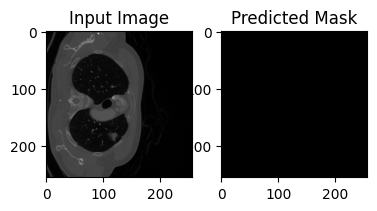

In [79]:
image_path = '/content/289.png'
segment_tumor(image_path, whole_img_model)

## **Tumor Detection**

In [75]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 847.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [76]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
#pretrained model
def tumor_detection(img_path, detection_model, conf=0.3):

    results = detection_model(img_path, conf=conf)

    boxes = results[0].boxes
    scores = results[0].boxes.conf.cpu().numpy()

    image = cv2.imread(img_path)

    for box in boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        conf = box.conf[0].item()
        label = box.cls[0].item()
        cv2.rectangle(image, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.putText(image, f"Tumor {conf:.2f}", (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)

    print(f'boxes: {boxes}')
    print(f'scores: {scores}')

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    return x1, y1, x2, y2


image 1/1 /content/289.png: 1024x1024 1 tumor, 2780.3ms
Speed: 77.4ms preprocess, 2780.3ms inference, 41.3ms postprocess per image at shape (1, 3, 1024, 1024)
boxes: ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.8026])
data: tensor([[105.5397, 175.8709, 126.7304, 194.5960,   0.8026,   0.0000]])
id: None
is_track: False
orig_shape: (256, 256)
shape: torch.Size([1, 6])
xywh: tensor([[116.1351, 185.2335,  21.1907,  18.7250]])
xywhn: tensor([[0.4537, 0.7236, 0.0828, 0.0731]])
xyxy: tensor([[105.5397, 175.8709, 126.7304, 194.5960]])
xyxyn: tensor([[0.4123, 0.6870, 0.4950, 0.7601]])
scores: [    0.80259]


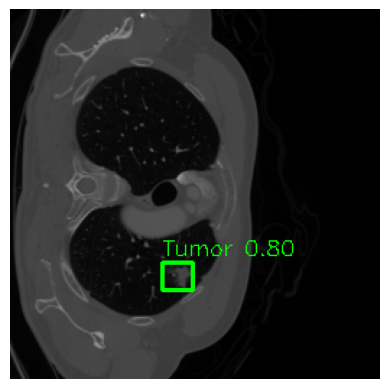

In [ ]:
detection_model = YOLO('/content/best(2).pt')
img_path='/content/289.png'
x1, y1, x2, y2 = tumor_detection(img_path, detection_model)

## **Segmentation of detected tumors**

In [61]:
class DoubleConv(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.15),  # Slightly increased dropout
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

In [62]:
class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, features=[32, 64, 128, 256]):
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()

        # Downsampling path (encoder)
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)

        # Upsampling path (decoder)
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature * 2, feature))

        # Final output layer
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)  # transpose conv
            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:])

            x = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](x)

        return self.final_conv(x)

In [63]:
model_detection = UNet().to(device)
model_detection.load_state_dict(torch.load(f"/content/drive/MyDrive/best_unet_cropped.pth", map_location=device))
model_detection.to(device)

UNet(
  (downs): ModuleList(
    (0): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Dropout2d(p=0.15, inplace=False)
        (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): ReLU(inplace=True)
      )
    )
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Dropout2d(p=0.15, inplace=False)
        (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (5): BatchNorm2d(64, eps=

In [81]:
img_path = '/content/289.png'
image = cv2.imread(img_path)

crop = image[y1:y2, x1:x2]

cv2.imwrite("tumor_crop.png", crop)
print(f"Saved cropped image: tumor_crop.png")

segment_tumor("tumor_crop.png", model_detection, detection=True)

NameError: name 'y1' is not defined